# Convolutional Neural Network model - an introduction (Part 1)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/paolodeangelis/Sistemi_a_combustione/blob/main/3.1-CNN_Intro_P1.ipynb)

## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to `Edit` > `Notebook Settings`
- Select `T4 GPU` from the Hardware Accelerator drop-down
- If the GPU nodes are busy, use the CPU one.

Next, we'll check that we can connect to the GPU:

In [ ]:
import warnings

import tensorflow as tf

print("Tensorflow version " + tf.__version__)

device_name = tf.test.gpu_device_name()  # GPU detection
if device_name == "/device:GPU:0":
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f"Running on GPU at: {device_name}")
else:
    warnings.warn("GPU device not found")
    try:
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(
            tpu=""
        )  # TPU detection
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.TPUStrategy(resolver)
        print(
            "Running on TPU at:",
            "\n\t".join([f"{i}" for i in tf.config.list_logical_devices("TPU")]),
        )
    except ValueError:
        warnings.warn("TPU device not found")
        warnings.warn("Default parallization strategy will be used")
        strategy = tf.distribute.get_strategy()

## Installing Libraries

We begin by installing the necessary libraries to support our data manipulation, visualization, and deep learning modeling. (Note: `Tensorflow` and `Keras` are already installed on Colab)

In [ ]:
%pip install numpy pandas scipy matplotlib  scikit-learn

And now we import the necessary libraries

In [14]:
import os  # Operating system-related functions
import pathlib  # Path manipulation and filesystem-related operations

import matplotlib.pyplot as plt  # Data visualization library
import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation and analysis library
import tensorflow as tf  # Deep learning framework for neural networks
from PIL import Image
from tensorflow.keras import Sequential, layers, losses, optimizers

## Data download and downsamplig

In this section, we will download the dataset MNIST (Modified database National Institute of Standards and Technology) is a collection of 70.000 handwritten 10-digit images, downsampled in size (28 × 28 pixels), in black and white and therefore with only one color channel.

### Download dataset files

Then we load the database. Because it is a standard database (a sort of *Hello World* for CNN), it is already included in TF, so we only need to run the following function:

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

#### Digital *raster* image

Wait? *Pixel*, *downsamplig*, color channels... but what is a digital image?

Raster images are a crucial element in digital graphics, such as those captured by digital cameras or smartphones. Essentially, raster images consist of pixels, each being a small square that represents a specific color. These pixels, when organized in a grid, create a complete image.

From a more mathematical perspective, a raster image can be viewed as a matrix, or more accurately, a tensor. In this structure, each element stores the color(-channel) value of a corresponding pixel.

Indeed we can manipulate the image as a `numpy` array.

In [12]:
!wget https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/assets/img/lena.png

--2023-11-15 15:51:02--  https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/assets/img/lena.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘lena.png’

lena.png            100%[===================>] 462.73K  --.-KB/s    in 0.06s   

2023-11-15 15:51:02 (7.76 MB/s) - ‘lena.png’ saved [473831/473831]



Let's load an image. This can be done using the `PIL` library, which supports a wide range of image formats. Once loaded, the image can be displayed using Matplotlib.

> ℹ️ : This image is not exactly random; it's called *Lena* and has been commonly used in journal articles related to image processing and analysis. If you are curious, you might want to check out the following [video](https://www.youtube.com/watch?v=yCdwm2vo09I).

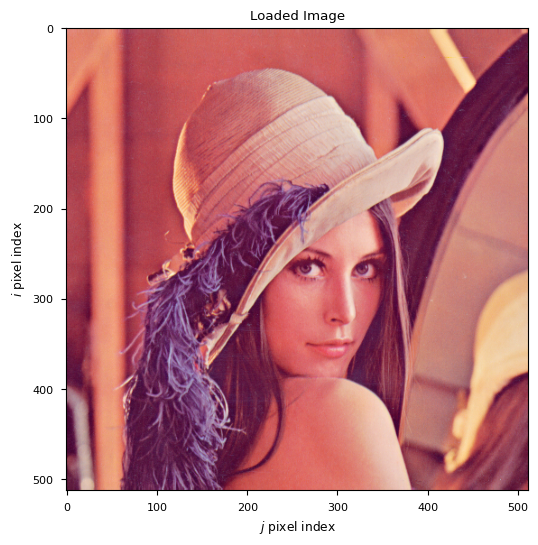

In [17]:
# Load an image
image = Image.open('lena.png')
fig = plt.figure(figsize=(6, 6))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    ax.imshow(image)
    ax.set_title('Loaded Image')
    ax.set_xlabel('$j$ pixel index')
    ax.set_ylabel('$i$ pixel index')
plt.show()


In Python, a raster image is represented as a multi-dimensional NumPy array. Each element of this array corresponds to a pixel in the image. The shape of the array provides information about the image's dimensions and color channels. For instance, an image with the shape (height, width, 3) indicates a typical RGB image with three color channels. In our case we have:

In [20]:
image_array = np.array(image)
print(f"Shape of the image array: {image_array.shape}")

Shape of the image array: (512, 512, 3)


Each pixel in a raster image is typically represented by a combination of color values. In a **24-bit RGB** color scheme, each color channel (Red, Green, Blue) is represented by 8 bits, allowing for $2^8 = 256$ levels of intensity.

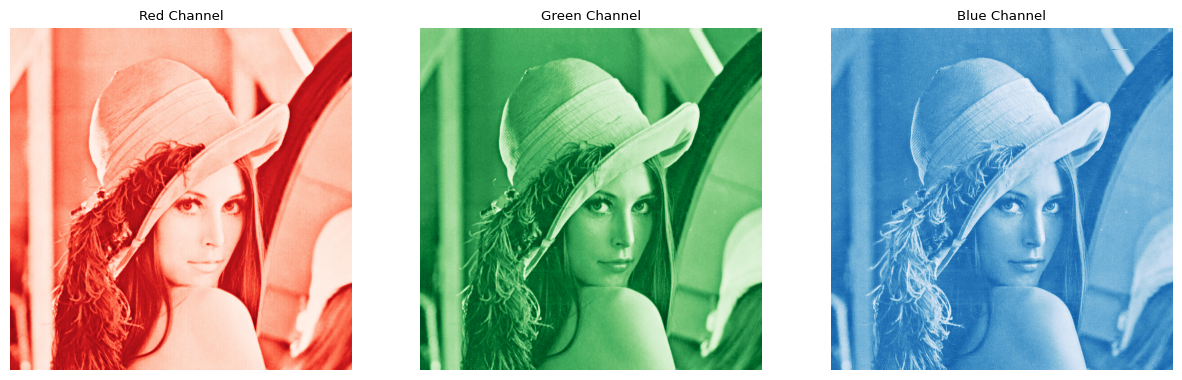

In [27]:
# Separate the channels
red_channel = image_array[:,:,0]
green_channel = image_array[:,:,1]
blue_channel = image_array[:,:,2]

# Display each channel
fig = plt.figure(figsize=(5*3, 5))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(131)
    ax.imshow(red_channel, cmap='Reds_r')
    ax.set_title('Red Channel')
    ax.axis('off')

    ax = fig.add_subplot(132)
    ax.imshow(green_channel, cmap='Greens_r')
    ax.set_title('Green Channel')
    ax.axis('off')

    ax = fig.add_subplot(133)
    ax.imshow(blue_channel, cmap='Blues_r')
    ax.set_title('Blue Channel')
    ax.axis('off')

plt.show()

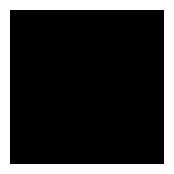

RGB: 0, 0, 0
BIN: 000000000000000000000000
HEX: # 000000


In [10]:
# @title RGB 24-bit widget

import ipywidgets as widgets
from IPython.display import display, clear_output

# Function to convert RGB to HEX
def rgb_to_hex(r, g, b):
    return "# {:02x}{:02x}{:02x}".format(r, g, b)

# Function to display the color and its values
def display_color(change):
    clear_output(wait=True)
    display(widget_box)  # Redisplay the widgets
    r, g, b = slider_r.value, slider_g.value, slider_b.value
    hex_color = rgb_to_hex(r, g, b)
    plt.figure(figsize=(2, 2))
    plt.imshow(np.array([[[r/255, g/255, b/255]]]))
    plt.axis('off')
    plt.show()
    print(f"RGB: {r}, {g}, {b}")
    print(f"BIN: {r:08b}{g:08b}{b:08b}")
    print(f"HEX: {hex_color}")

# Creating RGB sliders
slider_r = widgets.IntSlider(value=0, min=0, max=255, description='Red:', continuous_update=False)
slider_g = widgets.IntSlider(value=0, min=0, max=255, description='Green:', continuous_update=False)
slider_b = widgets.IntSlider(value=0, min=0, max=255, description='Blue:', continuous_update=False)

# Observing the sliders
slider_r.observe(display_color, names='value')
slider_g.observe(display_color, names='value')
slider_b.observe(display_color, names='value')

# Grouping the sliders for display
widget_box = widgets.VBox([slider_r, slider_g, slider_b])

# Displaying the widgets
display(widget_box)

# Initial display
display_color(None)


![working progress](https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/assets/img/warning-work-in-progress.jpg)